In [1]:
!pip install qiskit qiskit_aer --quiet
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
%matplotlib inline

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def qft_rotations(qc, n):
    """Apply QFT rotations recursively on the first n qubits."""
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qubit in range(n):
        qc.cp(np.pi / 2**(n - qubit), qubit, n)
    qft_rotations(qc, n)
    return qc

In [5]:
def swap_registers(qc, n):
    """Swap qubits to reverse their order."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

In [6]:
def qft_circuit(n):
    """Builds an n-qubit Quantum Fourier Transform circuit."""
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    swap_registers(qc, n)
    qc.name = "QFT"
    return qc

Running Quantum Fourier Transform on 3 qubits...


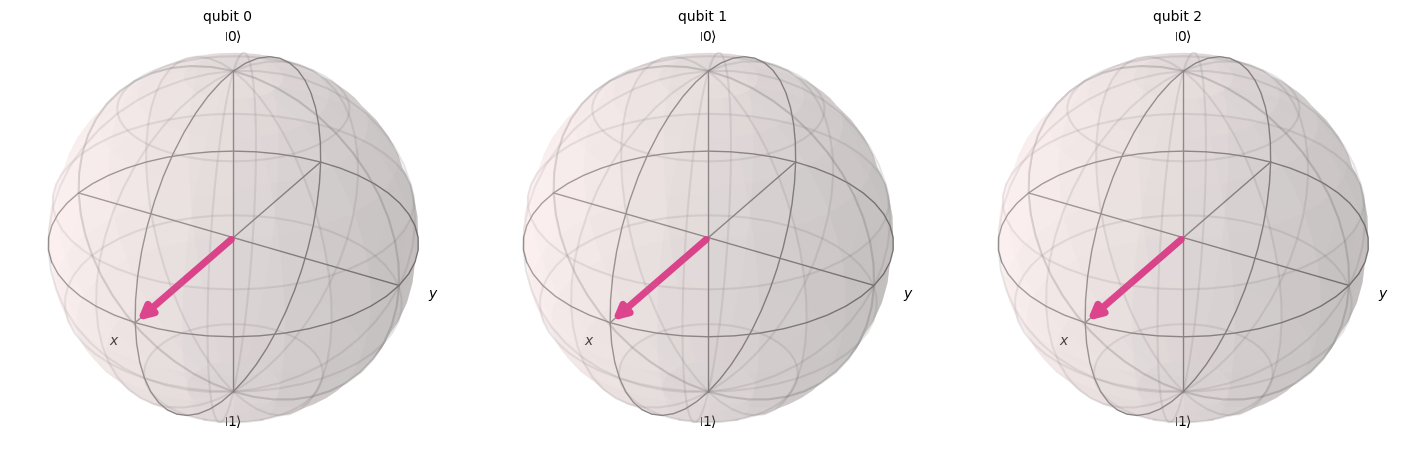

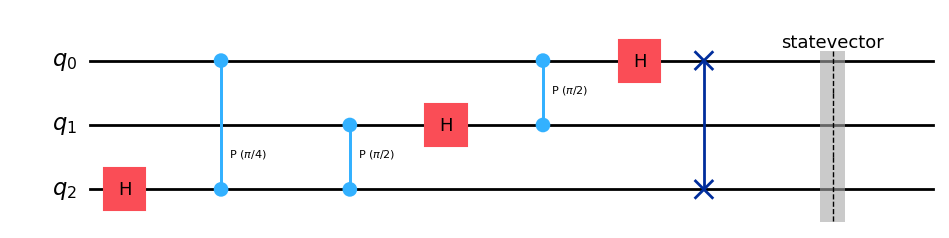

In [7]:
def run_qft(n):
    """Executes QFT circuit and displays Bloch sphere representation."""
    qc = qft_circuit(n)

    # Create a simulator and save the statevector explicitly
    simulator = AerSimulator(method='statevector')
    qc.save_statevector()

    # Transpile and run
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled).result()

    # Retrieve statevector safely
    statevector = result.data(0)["statevector"]

    # Display results
    plt = plot_bloch_multivector(statevector)
    plt.show()
    display(plt)
    display(qc.draw("mpl"))
if __name__ == "__main__":
    n_qubits = 3
    print(f"Running Quantum Fourier Transform on {n_qubits} qubits...")
    run_qft(n_qubits)

# **Task 1: Vary the number of qubits**


--- QFT circuit with 2 qubits ---


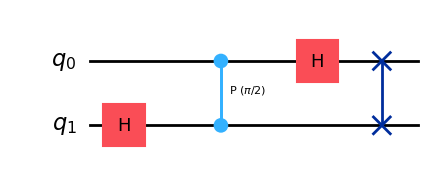


--- QFT circuit with 3 qubits ---


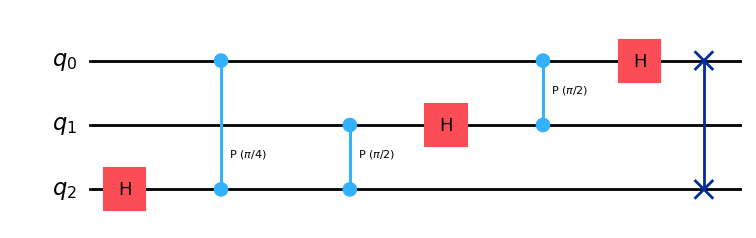


--- QFT circuit with 4 qubits ---


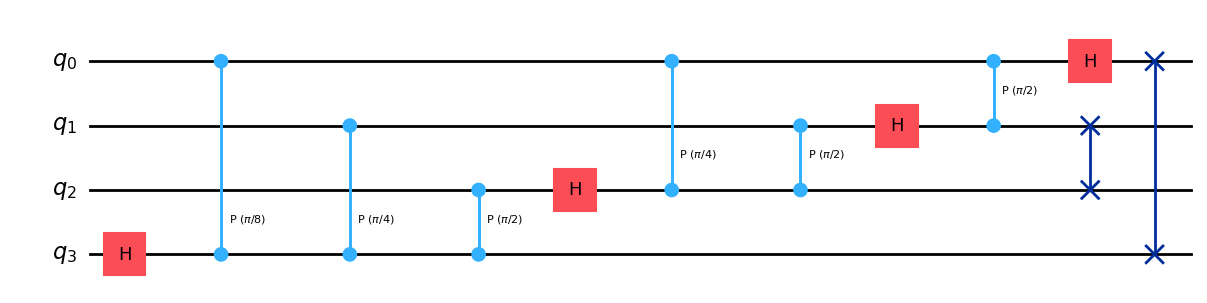

In [8]:
from qiskit import QuantumCircuit
import numpy as np

def qft_rotations(qc, n):
    if n == 0:
        return
    n -= 1
    qc.h(n)
    for q in range(n):
        qc.cp(np.pi / 2 ** (n - q), q, n)
    qft_rotations(qc, n)

def swap_registers(qc, n):
    for q in range(n // 2):
        qc.swap(q, n - q - 1)

def qft_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qft_rotations(qc, num_qubits)
    swap_registers(qc, num_qubits)
    qc.name = "QFT"
    return qc

# Display QFT circuits for 2–4 qubits
for n in [2, 3, 4]:
    print(f"\n--- QFT circuit with {n} qubits ---")
    display(qft_circuit(n).draw("mpl"))



# **Task 2:  Inverse QFT (IQFT)**

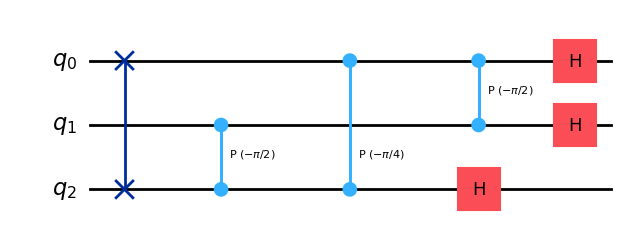

In [9]:
from qiskit import QuantumCircuit
import numpy as np

def inverse_qft(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # Reverse swap order first
    for q in range(num_qubits // 2):
        qc.swap(q, num_qubits - q - 1)
    # Apply inverse rotations
    for j in range(num_qubits - 1, -1, -1):
        for k in range(j - 1, -1, -1):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    qc.name = "Inverse QFT"
    return qc

iqft = inverse_qft(3)
display(iqft.draw("mpl"))


# **Task 3: Quantum Phase Estimation (QPE)**

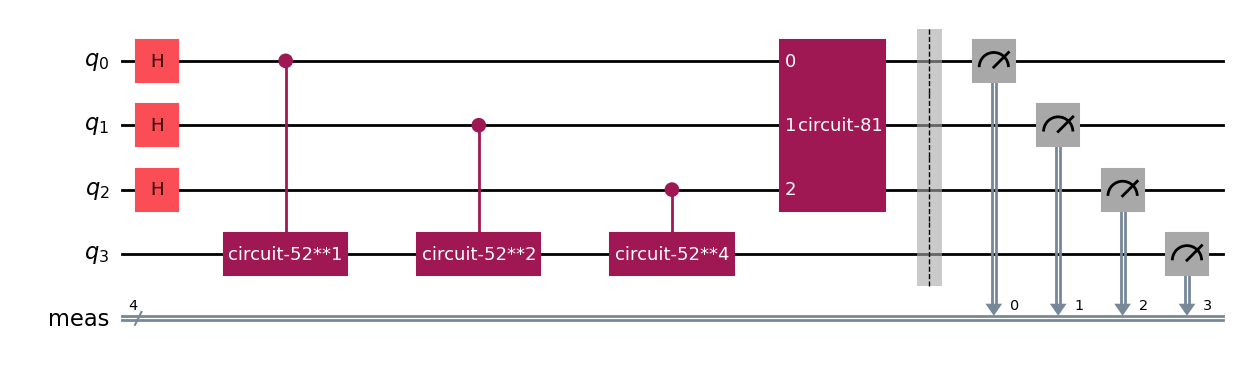

In [10]:
from qiskit import QuantumCircuit
import numpy as np

def inverse_qft(num_ancillas):
    qc = QuantumCircuit(num_ancillas)
    for j in range(num_ancillas // 2):
        qc.swap(j, num_ancillas - j - 1)
    for j in range(num_ancillas - 1, -1, -1):
        for k in range(j - 1, -1, -1):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc

def phase_estimation(unitary, ancillas):
    n_target = unitary.num_qubits
    qc = QuantumCircuit(ancillas + n_target)
    # Prepare ancilla register
    qc.h(range(ancillas))
    # Controlled-U^(2^k)
    for k in range(ancillas):
        qc.append(unitary.power(2 ** k).to_gate().control(1),
                  [k] + list(range(ancillas, ancillas + n_target)))
    # Apply inverse QFT
    qc.append(inverse_qft(ancillas).to_gate(), range(ancillas))
    qc.measure_all()
    return qc

# Example: 1-qubit unitary with known phase
phi = 1 / 4
U = QuantumCircuit(1)
U.p(2 * np.pi * phi, 0)

qpe_circuit = phase_estimation(U, 3)
display(qpe_circuit.draw("mpl"))


# **Task 4: Measure Output States**

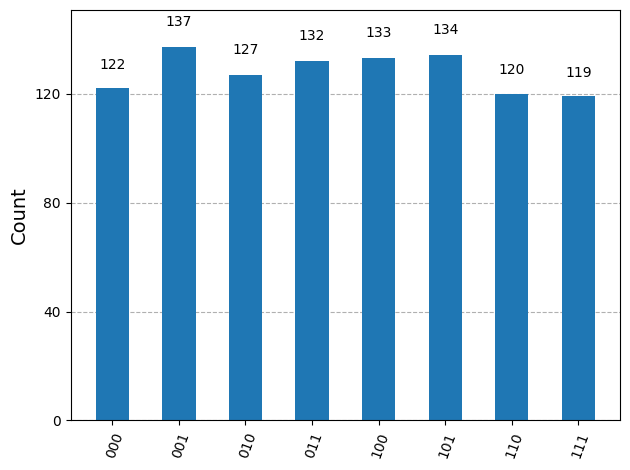

Measurement counts: {'100': 133, '010': 127, '000': 122, '001': 137, '111': 119, '011': 132, '110': 120, '101': 134}


In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

def qft_circuit(n):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
        for j in range(i + 1, n):
            qc.cp(np.pi / 2 ** (j - i), j, i)
    qc.measure_all()
    return qc

def run_qft_with_measurement(n):
    sim = AerSimulator()
    qc = qft_circuit(n)
    compiled = transpile(qc, sim)
    result = sim.run(compiled, shots=1024).result()
    counts = result.get_counts()
    plt1 = plot_histogram(counts)
    display(plt1)
    plt.show()
    print("Measurement counts:", counts)

run_qft_with_measurement(3)


# **Task 5: Circuit Visualization**

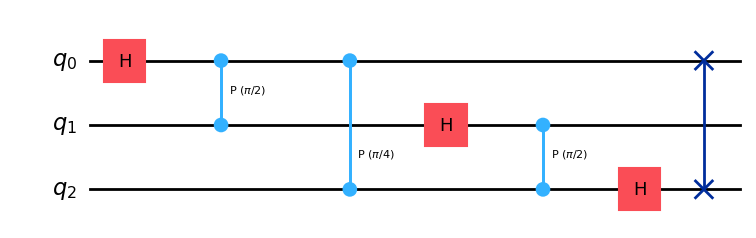

In [12]:
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt

def qft_circuit_viz(n):
    qc = QuantumCircuit(n)
    for j in range(n):
        qc.h(j)
        for k in range(j + 1, n):
            qc.cp(np.pi / 2 ** (k - j), k, j)
    for q in range(n // 2):
        qc.swap(q, n - q - 1)
    qc.name = "QFT"
    return qc

# Build and display the circuit
qc_viz = qft_circuit_viz(3)
qc_viz.draw('mpl')